In [22]:
from PIL import Image
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import numpy as np
import cv2
import os
from os import listdir

import math
import imageio
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib import image

%matplotlib inline

from glob import glob 
import re

import xml.etree.ElementTree as ET
import shutil



In [23]:
data_dir="data"

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
card_dir = "data/cards"

if not os.path.isdir(card_dir):
    os.makedirs(img_dir)

cards = []
for c in listdir(card_dir):
    img = image.imread(card_dir +'/' + c,1)
    cards.append(img)


In [24]:
cardW=63
cardH=88
cornerXmin=2
cornerXmax=43
cornerYmin=2
cornerYmax=43
mmToPixel = 3.7795


card_suits=['s','h','d','c']
card_values=['A','K','Q','J','10','9','8','7','6','5','4','3','2']

# We convert the measures from mm to pixels: multiply by an arbitrary factor 'zoom'
# You shouldn't need to change this
zoom=1
cardW*=zoom
cardH*=zoom

corners = [cornerXmin,cornerXmax,cornerYmin,cornerYmax]
print(corners)
corners = [int(i*zoom*mmToPixel) for i in corners]

pixelW = math.ceil(cardW * mmToPixel)
pixelH = math.ceil(cardH * mmToPixel)


cards = [ia.imresize_single_image(i, (pixelH, pixelW)) for i in cards]

print(corners)

[2, 43, 2, 43]
[7, 162, 7, 162]


2


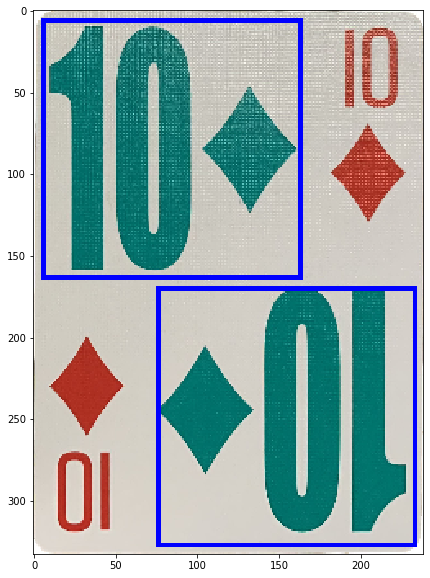

In [25]:

bbs = BoundingBoxesOnImage([
    BoundingBox(x1=corners[0], x2=corners[1], y1=corners[2], y2=corners[3]),
    BoundingBox(x1=pixelW-corners[0], x2=pixelW-corners[1], y1=pixelH-corners[2], y2=pixelH-corners[3])
], shape=img.shape)

print(cornerXmin)

image_before = bbs.draw_on_image(cards[3], size=3,color=[0, 0, 255])

#ia.imshow(bbs.draw_on_image(images, size=2))
# cv2.imshow('image',image_before)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.figure(figsize=(10,10))
plt.imshow(image_before) # display the image

plt.show()


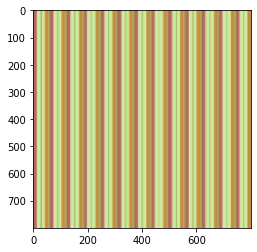

In [26]:
#Grab background and resize background
backgrounds = []
background_dir = "data/dtd/images"
backgroundW = 800

c = 0
for subfolder in listdir(background_dir):
    for b in listdir(background_dir+"/"+subfolder):
        img = image.imread(background_dir + '/' + subfolder + '/' + b)
        img = ia.imresize_single_image(img, (backgroundW, backgroundW))
        backgrounds.append(img)
        c+=1
        if c == 2:
            break
    if c==2:
        break
_=plt.imshow(backgrounds[0])            
        
            

BB 0: (7.0000, 7.0000, 162.0000, 162.0000) -> (285.4926, 479.0479, 373.9342, 567.4895)
BB 1: (77.0000, 171.0000, 232.0000, 326.0000) -> (325.4340, 572.6248, 413.8755, 661.0664)


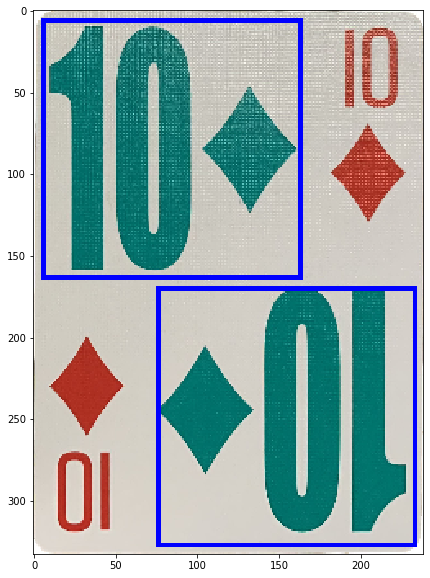

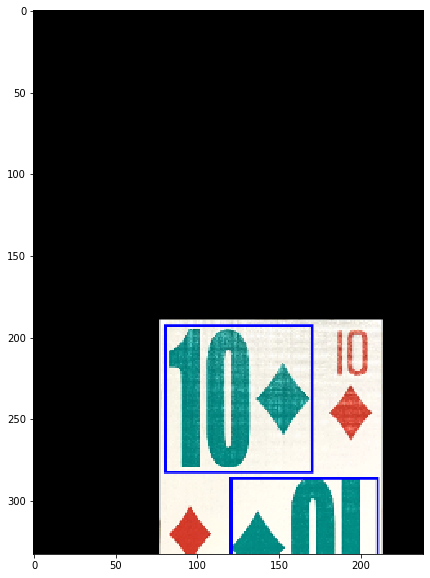

In [27]:
import random
#Augment cards and bounding boxes
x = random.randint(5,200)
y = random.randint(5,200)
seq = iaa.Sequential([
    iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
    iaa.Affine(
        translate_px={"x": x, "y": y},
        scale=(0.5, 0.7)
    ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
])

image_aug, bbs_aug = seq(image=image_before, bounding_boxes=bbs)

# print coordinates before/after augmentation (see below)
# use .x1_int, .y_int, ... to get integer coordinates
for i in range(len(bbs.bounding_boxes)):
    before = bbs.bounding_boxes[i]
    after = bbs_aug.bounding_boxes[i]
    print("BB %d: (%.4f, %.4f, %.4f, %.4f) -> (%.4f, %.4f, %.4f, %.4f)" % (
        i,
        before.x1, before.y1, before.x2, before.y2,
        after.x1, after.y1, after.x2, after.y2)
    )

image_after = bbs_aug.draw_on_image(image_aug, size=2, color=[0, 0, 255])

plt.figure(figsize=(10,10))
plt.imshow(image_before) # display the image
plt.figure(figsize=(10,10))
plt.imshow(image_after) # display the image


In [28]:
#Convert white space to transparent background on cards
for i in range(len(cards)):
    cards[i] = Image.fromarray(cards[i])
    cards[i] = cards[i].convert("RGBA")
    pixelMap = cards[i].load()
    w,h = cards[i].size
    for y in range(h):
        for x in range(w):
            if pixelMap[x, y] == (255, 255, 255, 255):
                pixelMap[x, y] = (255, 255, 255, 0)
    cards[i] = np.asarray(cards[i])




#Paste cards onto background
background = Image.fromarray(backgrounds[0])
background = background.convert("RGBA")
card = Image.fromarray(cards[3])

print(card.mode)

background.paste(card, (0,0), card)
background.show()


RGBA


In [30]:
image_after = Image.fromarray(image_after)
image_after = image_after.convert("RGBA")
print(image_after.mode)
pixelMap =image_after.load()
w,h = image_after.size
for y in range(h):
    for x in range(w):
        if pixelMap[x, y] == (255, 255, 255, 255):
            pixelMap[x, y] = (255, 255, 255, 0)
image_after.show()
background.paste(image_after, (0,0), image_after)
background.show()

TypeError: expected string or buffer

In [ ]:
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""